In [9]:
import sqlite3
from sqlite3 import Error
import json
import time
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import category_encoders as ce

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier, XGBRFRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from wordcloud import WordCloud

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
def XGBRFRegressor_pipeline(train, train_labels):

    rfr = XGBRFRegressor(n_jobs=-1, random_state=42, objective = 'reg:squarederror')

    param_grid = {
            'n_estimators': [100],
            'max_features': ['sqrt'],
            'max_depth': [10],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'min_child_weight':[10],
            'learning_rate':[1],
          }

    # cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(sublinear_tf=True, stop_words='english')),
        ('rfr', GridSearchCV(estimator=rfr, verbose=10, param_grid=param_grid, cv=5)),
    ])
    # scoring='roc_auc'

    pipeline.fit(train, train_labels)

    print('Validation Accuracy: ', pipeline.named_steps['rfr'].best_score_)
    print('Best Parameters: ', pipeline.named_steps['rfr'].best_params_)
    
    return pipeline

In [11]:
def XGBRFClassifier_pipeline(train, train_labels):

    rfr = XGBRFClassifier(n_jobs=-1, random_state=42, objective = 'binary:logistic')

    param_grid = {
            'n_estimators': [100],
            'max_features': ['sqrt'],
            'max_depth': [10],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'min_child_weight':[10],
            'learning_rate':[1],
          }

    # cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(sublinear_tf=True, stop_words='english')),
        ('rfr', GridSearchCV(estimator=rfr, verbose=10, param_grid=param_grid, cv=5)),
    ])
    # scoring='roc_auc'

    pipeline.fit(train, train_labels)

    print('Validation Accuracy: ', pipeline.named_steps['rfr'].best_score_)
    print('Best Parameters: ', pipeline.named_steps['rfr'].best_params_)
    
    return pipeline

# Load Dataframe From SQL

In [27]:
df = pd.DataFrame()
for i in range(1,11):
    sql_str = f'''
                SELECT meme_text, ups
                FROM month_{i}
                WHERE meme_text IS NOT NULL
                AND ups > 3;
                '''
    with sqlite3.connect("memes.db") as db:
        temp = pd.read_sql(sql_str, db)
    df = pd.concat([df,temp])
df =df.reset_index(drop=True)

# Some Filtering for unuseful API responses

In [28]:
mask = ((df['meme_text']!='empty') & (df['meme_text']!='404') & (df['meme_text']!='connection error'))
text_df = df[mask]

# Fix text and transform upvotes

In [29]:
text_df.loc[:,'text_list'] = text_df.loc[:,'meme_text'].apply(lambda d: " ".join([value for key, value in json.loads(d).items()]))
text_df.loc[:,'log_ups'] =  (text_df.loc[:,'ups'].astype(float)).apply(np.log)
text_df.loc[:,'boxcox_ups'], boxcox_lambda =  boxcox(text_df.loc[:,'ups'].astype(float))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


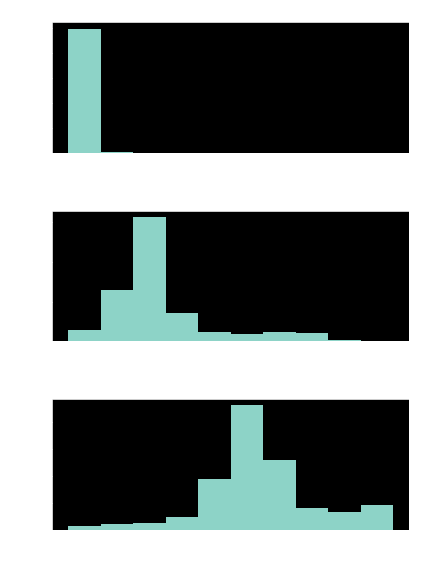

In [30]:
# Distribution of Upvotes
plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
plt.title('Distribution of Upvotes')
plt.hist(text_df['ups'])
plt.xlabel('Upvotes per Post')

plt.subplot(3,1,2)
plt.title('Log Transformed Distribution of Upvotes')
plt.hist(text_df['log_ups'])
plt.xlabel('Upvotes per Post(log)')
plt.savefig('upvote_distro.png', bbox_inches='tight')

plt.subplot(3,1,3)
plt.title('boxcox Transformed Distribution of Upvotes')
plt.hist(text_df['boxcox_ups'])
plt.xlabel('Upvotes per Post(boxcox)')
plt.tight_layout()
plt.savefig('upvote_distro.png', bbox_inches='tight')
plt.show()


In [7]:
train, holdout, train_labels, holdout_labels = train_test_split(text_df.text_list, 
                                                                text_df.boxcox_ups, 
                                                                test_size=0.10,
                                                                random_state=42)

In [8]:
pipeline = build_pipeline(train,train_labels.values.flatten())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] learning_rate=1, max_depth=10, max_features=sqrt, min_child_weight=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  learning_rate=1, max_depth=10, max_features=sqrt, min_child_weight=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.040, total=  48.6s
[CV] learning_rate=1, max_depth=10, max_features=sqrt, min_child_weight=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.5s remaining:    0.0s
[CV]  learning_rate=1, max_depth=10, max_features=sqrt, min_child_weight=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.037, total=  48.5s
[CV] learning_rate=1, max_depth=10, max_features=sqrt, min_child_weight=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[Parallel(n_jobs=1)]: Done   2 out of   2 | elaps

In [23]:
pred = pipeline.predict(holdout)

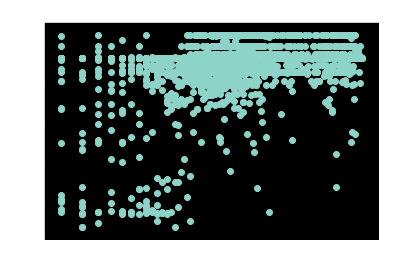

In [24]:
plt.scatter(holdout_labels, pred)
plt.xlabel('True Upvotes')
plt.ylabel('Predicted Upvotes')
plt.title('XGB Random Forest Regressor')
plt.savefig('XGBRFR_confusion.png', bbox_inches='tight')
plt.show()

In [25]:
text_df.shape

(126359, 2)

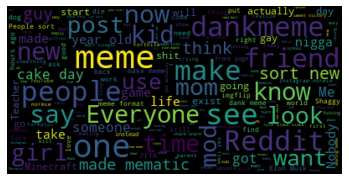

In [33]:
text = ' '.join(text_df['text_list'].values)
wordcloud = WordCloud(background_color="black", max_font_size=40).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('word_cloud.png', bbox_inches='tight')
plt.show()